In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
dataDir='/data/dataset/coco'

### Adding some helper functions

In [4]:
def getCocoFromAnnotations(annFile):
        coco=COCO(annFile)
        return coco

def showImage(img):
    # load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    # print(img)
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
def writeToFile(outdoorImages, dataType):
    filename = f'{dataType}_outdoor'
    print(f'\n Writing OutdoorImageIds to file {filename}')
    file1 = open(f'all_outdoor', 'w+')
    imageName = [img['file_name'] for img in outdoorImages]
    file1.writelines(json.dumps(imageName))

### Outdoor Dataset Generator can be used to get Outdoor Image Ids

In [5]:
class OutdoorDatasetGenerator:
    def __init__(self, coco):
        self.coco = coco
    
    def getCocoCategories(self):
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        print(f'There are {len(cats)} coco categories')
        return cats

    def getSuperCategories(self):
        cats = self.getCocoCategories()
        supercats = set([cat['supercategory'] for cat in cats])
        print(f'There are {len(supercats)} coco supercategories')
        # print('COCO supercategories: \n{}'.format(' '.join(nms)))
        return supercats

    def getOutdoorCategories(self):
        cats = self.getCocoCategories()
        outdoorCats = []
        for category in cats:
            if category['supercategory'] == 'outdoor' or category['supercategory'] == 'vehicle':
                outdoorCats.append(category['name'])
        print('Outdoor Categories are', outdoorCats)
        return outdoorCats

    def getOutdoorImageIds(self):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        for cat in outdoorCats:
            catId = self.coco.getCatIds(catNms=[cat])[0];
            images = self.coco.getImgIds(catIds=catId)
            outdoorImageIds.extend(images)
        outdoorImageIds = list(set(outdoorImageIds))
        print(f'Total outdoor images are {len(outdoorImageIds)}')
        return outdoorImageIds
    
    def getImageForCategory(self, cat):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        catId = self.coco.getCatIds(catNms=[cat])[0];
        images = self.coco.getImgIds(catIds=catId)
        return images
    
    def getCategoryForImage(self, imgId):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        for cat in outdoorCats:
            catId = self.coco.getCatIds(catNms=[cat])[0];
            images = self.coco.getImgIds(catIds=catId)
            #outdoorImageIds.extend(images)
            if imgId in images:
                print(cat)
    
    def getImage(self, imgId):
        return self.coco.loadImgs(imgId)[0]

In [20]:
def GetOutdoorImages(dataType, instanceFile):
    print(f'Generating outdoor image dataset for {dataType}\n')
    print('Initialising COCO object for Instances data')
    instanceDataCoco = getCocoFromAnnotations(instanceFile)
    generator = OutdoorDatasetGenerator(instanceDataCoco)
    imageIds =  generator.getOutdoorImageIds()
    images = [generator.getImage(id) for id in imageIds]
    # print(len(images))
    return images

def GetCategoryFromImage(dataType, instanceFile, imgId):
    instanceDataCoco = getCocoFromAnnotations(instanceFile)
    generator = OutdoorDatasetGenerator(instanceDataCoco)
    generator.getCategoryForImage(imgId)

In [13]:
dataType='train2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
trainOutdoorImages = GetOutdoorImages(dataType, instanceFile)

dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
valOutdoorImages = GetOutdoorImages(dataType, instanceFile)

# print(len)
# writeToFile(trainOutdoorImages.extend(valOutdoorImages), dataType)

Generating outdoor image dataset for train2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=12.67s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 23686
Generating outdoor image dataset for val2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=5.51s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


##  Getting the dataset for the test set

In [14]:
allImages = trainOutdoorImages+ valOutdoorImages
writeToFile(allImages, dataType)

print(len(allImages[0:20000]))
print(len(trainOutdoorImages))
print(len(valOutdoorImages))


 Writing OutdoorImageIds to file val2014_outdoor
20000
23686
11537


In [7]:
dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
outdoorImages = GetOutdoorImages(dataType, instanceFile)
# writeToFile(outdoorImages, dataType)

Generating outdoor image dataset for val2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=5.23s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


### Captions Viewer can be used to get the captions given an image

In [24]:
class CaptionsViewer:
    def __init__(self, coco):
        self.coco = coco
        
    def showCaptions(self, img):
        annIds = self.coco.getAnnIds(imgIds=img['id']);
        anns = self.coco.loadAnns(annIds)
        # self.coco.showAnns(anns)
        # showImage(img)
        return anns

In [29]:
# dataType='train2017'
dataType='val2017'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
outdoorImages = GetOutdoorImages(dataType, instanceFile)

print('\nGetting random outdoor image')
img = outdoorImages[np.random.randint(0,len(outdoorImages))]

captionsFile='{}/annotations/captions_{}.json'.format(dataDir, dataType)
captionsDataCoco = getCocoFromAnnotations(captionsFile)
print(f'\nCaptions for Image: {img} are\n')
captionsViewer = CaptionsViewer(captionsDataCoco)
print(captionsViewer.showCaptions(img))

Generating outdoor image dataset for val2017

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 1424

Getting random outdoor image
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!

Captions for Image: {'license': 3, 'file_name': '000000472030.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000472030.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 19:50:55', 'flickr_url': 'http://farm4.staticflickr.com/3340/3570719653_be3552d961_z.jpg', 'id': 472030} are

[{'image_id': 472030, 'id': 503953, 'caption': 'A lush green forest filled with lots of trees.'}, {'image_id': 472030, 'id': 507424, 'caption': 'A jacket is draped on a bench 

In [25]:
img = outdoorImages[np.random.randint(0,len(outdoorImages))]
captionsViewer = CaptionsViewer(captionsDataCoco)
anns = captionsViewer.showCaptions(img)
print(anns)

[{'image_id': 238117, 'id': 829360, 'caption': 'A sky blue aircraft is displayed in front of a building, with clouds overhead.'}, {'image_id': 238117, 'id': 829473, 'caption': 'A large blue airplane parked in a stationary position.'}, {'image_id': 238117, 'id': 829657, 'caption': 'A big fighter jet sits on the te'}, {'image_id': 238117, 'id': 829695, 'caption': 'A jet aircraft strangely painted like the sky with clouds on display at an airport'}, {'image_id': 238117, 'id': 829719, 'caption': 'A blue camouflage airplane is on a runway.'}]


In [32]:
# Calculating if there are any images without any captions
nocaps = 0
for i in outdoorImages:
    anns = captionsViewer.showCaptions(i)
    if(len(anns) == 0):
        nocaps = nocaps+1

print(nocaps)

0


In [22]:
len(outdoorImages)

33799

In [15]:
with open('all_outdoor') as f:
  newImages = json.load(f)

p = 'COCO_val2014_000000216228.jpg'

if p not in newImages:
    print('hello')

In [16]:
len(newImages)

35223

In [10]:
for image in outdoorImages:
    if image['file_name'] == 'COCO_val2014_000000065182.jpg':
        print(image)

{'license': 3, 'file_name': 'COCO_val2014_000000065182.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000065182.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-21 02:12:33', 'flickr_url': 'http://farm6.staticflickr.com/5523/9450264273_c3d32c453b_z.jpg', 'id': 65182}


In [9]:
print(outdoorImages[0])

{'license': 3, 'file_name': 'COCO_val2014_000000360449.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000360449.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 16:22:20', 'flickr_url': 'http://farm5.staticflickr.com/4037/4455673413_cbb91bb389_z.jpg', 'id': 360449}


In [9]:
dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
instanceDataCoco = getCocoFromAnnotations(instanceFile)
generator = OutdoorDatasetGenerator(instanceDataCoco)
imageIds =  generator.getImageForCategory('traffic light')
outdoorImages = generator.getOutdoorImageIds()
imageIds

loading annotations into memory...
Done (t=5.81s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


[360449,
 221190,
 368648,
 393226,
 253964,
 106508,
 57363,
 565269,
 155671,
 507927,
 270376,
 532530,
 557127,
 393288,
 57415,
 204871,
 204887,
 532568,
 458846,
 532580,
 229478,
 475238,
 475244,
 319607,
 434316,
 8333,
 41119,
 385190,
 319655,
 32941,
 311471,
 106677,
 540860,
 565438,
 205002,
 139468,
 524507,
 499950,
 524533,
 549119,
 581887,
 257,
 90373,
 213255,
 499983,
 24851,
 213276,
 180515,
 246057,
 385346,
 90442,
 254283,
 475484,
 418144,
 359,
 418152,
 328041,
 262505,
 74096,
 344439,
 442746,
 516476,
 565635,
 205190,
 508302,
 205206,
 123289,
 33208,
 172478,
 156098,
 262609,
 270810,
 213475,
 246248,
 573930,
 279024,
 188918,
 90616,
 573947,
 385535,
 295426,
 475660,
 221713,
 565778,
 221737,
 279081,
 492077,
 467511,
 8762,
 221754,
 287291,
 115266,
 361029,
 492102,
 311883,
 533069,
 459342,
 213593,
 516708,
 328316,
 361103,
 213649,
 451228,
 172702,
 434850,
 123555,
 287396,
 246435,
 516775,
 279221,
 699,
 549568,
 336579,
 33489

{'license': 3, 'file_name': 'COCO_val2014_000000156370.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000156370.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 14:06:59', 'flickr_url': 'http://farm8.staticflickr.com/7014/6488659257_da002be495_z.jpg', 'id': 156370}


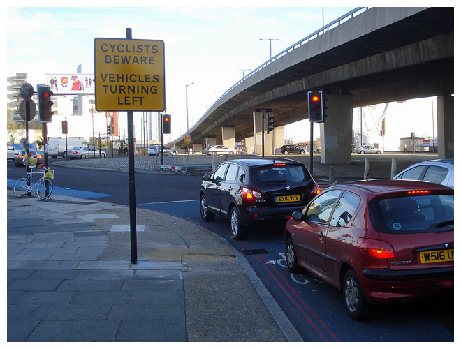

In [21]:
# for imageId in outdoorImages:

image = generator.getImage(156370)
print(image)
showImage(image)
